In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
L = 64
# Ne = L // 2
Ne = 4
rng = np.random.default_rng(42)
pos = rng.choice(L, size=Ne, replace=False)

lattice = np.full(L, False)
lattice[pos] = True
pos

array([28,  5, 41, 47])

-0.17677218835843977


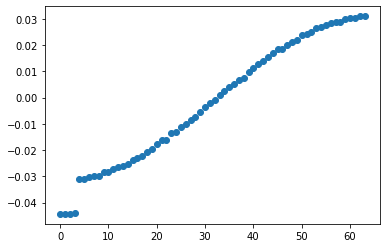

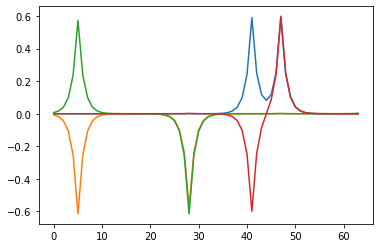

In [4]:
t = 1
U = 2
isPBC = True  # periodic boundary conditions


# H_kinetic = np.zeros((L, L), dtype=np.float32)
above_diag = np.diag(t * np.ones(L - 1), k=1)
below_diag = np.diag(np.conj(t) * np.ones(L - 1), k=-1)
H_kinetic = above_diag + below_diag
if isPBC:
    H_kinetic[0, -1] = np.conj(t)
    H_kinetic[-1, 0] = t


H = -H_kinetic - np.diag(U * lattice)

w, v = np.linalg.eigh(H)

energy = np.sum(w[:Ne]) / L
print(energy)

plt.scatter(range(L), w / L)
plt.show()

# sns.heatmap(np.transpose(v[:, :Ne]))
# plt.show()

plt.plot(v[:, :Ne])
plt.show()

testy gym

In [5]:
from gym import spaces

In [6]:
obs_space = spaces.MultiBinary(L)
tmp = obs_space.sample()

pos = rng.choice(L, size=Ne, replace=False)

lattice = np.full(L, False)
lattice[pos] = True

# gym

In [7]:
import gym
import numpy as np
import torch
from torch import nn
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from datetime import datetime
from gym.wrappers import TimeLimit


from sb3_contrib import MaskablePPO

# from sb3_contrib.common.envs import InvalidActionEnvDiscrete
from sb3_contrib.common.maskable.evaluation import evaluate_policy
from sb3_contrib.common.maskable.utils import get_action_masks

## CustomCNN

In [8]:
class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """

    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 256):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        # Re-ordering will be done by pre-preprocessing or wrapper
        n_input_channels = 1
        self.cnn = nn.Sequential(
            nn.Conv1d(n_input_channels, 32, kernel_size=3),
            nn.BatchNorm1d(),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm1d(),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with torch.no_grad():
            #! code repetition
            n_flatten = self.cnn(
                F.pad(
                    torch.as_tensor(observation_space.sample()[None])
                    .unsqueeze(-2)
                    .float(),
                    pad=(1, 1),
                    mode="circular",
                )
            ).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        # circular boundry conditions and add channel dimmension
        return self.linear(
            self.cnn(F.pad(observations.unsqueeze(-2), pad=(1, 1), mode="circular"))
        )


policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=128),
)

In [9]:
side_length = 8
env = gym.make(
    "gym_xymodel:falicovkimball1D-v0",
    L=side_length,
    Ne=side_length // 2,
    max_steps=side_length // 2,
)
# env = TimeLimit(env, max_episode_steps=100)
from stable_baselines3.common.env_checker import check_env

check_env(env)
# env = gym.make('CartPole-v1')
# env.observation_space.shape
# env.action_space.n

## PPO

In [9]:
date = datetime.now().strftime("%Y-%m-%dT%H%M%S")
folder_path = f"../results/falicovkimball1D/{date}_L{side_length}"
# model = PPO("MlpPolicy", env, tensorboard_log=folder_path)
model = PPO("MlpPolicy", env, tensorboard_log=folder_path, verbose=1)
model.learn(60000)
model.save(f"{folder_path}/model")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ../results/falicovkimball1D/2022-10-22T134250_L16/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.9      |
|    ep_rew_mean     | 1.26     |
| time/              |          |
|    fps             | 172      |
|    iterations      | 1        |
|    time_elapsed    | 11       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 5.79        |
|    ep_rew_mean          | 1.26        |
| time/                   |             |
|    fps                  | 148         |
|    iterations           | 2           |
|    time_elapsed         | 27          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012631256 |
|    clip_fraction        | 0.125   

## MaskablePPO

In [10]:
date = datetime.now().strftime("%Y-%m-%dT%H%M%S")
folder_path = f"../results/falicovkimball1D/{date}_L{side_length}_maskable"
# model = PPO("MlpPolicy", env, tensorboard_log=folder_path)
model = MaskablePPO("MlpPolicy", env, policy_kwargs=policy_kwargs tensorboard_log=folder_path, verbose=1)
model.learn(200_000)
# evaluate_policy(model, env, n_eval_episodes=20, reward_threshold=90, warn=False)
model.save(f"{folder_path}/model")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ../results/falicovkimball1D/2022-10-22T142108_L16_maskable/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.89     |
|    ep_rew_mean     | 1.26     |
| time/              |          |
|    fps             | 120      |
|    iterations      | 1        |
|    time_elapsed    | 17       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 5.71        |
|    ep_rew_mean          | 1.26        |
| time/                   |             |
|    fps                  | 92          |
|    iterations           | 2           |
|    time_elapsed         | 44          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.014570062 |
|    clip_fraction        |

## Maskable PPO - CNN

In [11]:
date = datetime.now().strftime("%Y-%m-%dT%H%M%S")
folder_path = f"../results/falicovkimball1D/{date}_L{side_length}_maskable_CNN"
# model = PPO("MlpPolicy", env, tensorboard_log=folder_path)
model = MaskablePPO("MlpPolicy", env, tensorboard_log=folder_path, verbose=1)
model.learn(200_000)
# evaluate_policy(model, env, n_eval_episodes=20, reward_threshold=90, warn=False)
model.save(f"{folder_path}/model")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ../results/falicovkimball1D/2022-10-24T180638_L8_maskable_CNN/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.49     |
|    ep_rew_mean     | 1.26     |
| time/              |          |
|    fps             | 61       |
|    iterations      | 1        |
|    time_elapsed    | 33       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.43        |
|    ep_rew_mean          | 1.26        |
| time/                   |             |
|    fps                  | 56          |
|    iterations           | 2           |
|    time_elapsed         | 72          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011495803 |
|    clip_fraction      

## Test env

[ True False False  True  True  True False False]
[ True False  True False  True  True False False]
[ True False  True False  True False  True False]
[ True False  True False  True False  True False]
[ True False  True False  True False  True False]
[ True False  True False  True False  True False]
[ True False  True False  True False  True False]
[ True False  True False  True False  True False]
reward=1.3375211990796931
[ True False  True False  True False  True False]


-1.3375211990796931

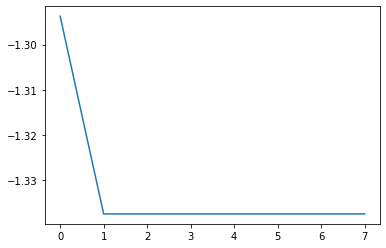

In [11]:
energies = []
obs = env.reset()
for i in range(200):
    print(env.state)
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    energies.append(env.compute_energy())
    if done:
        print(f"{reward=}")
        print(env.state)
        break
        # env.reset()
    # if i % 100 == 0:
    #   print(f"{i=}, {reward=}")
    #   env.render()

plt.plot(energies)
energies[-1]

array([ True, False,  True, False, False,  True, False,  True, False,
        True, False,  True,  True, False,  True, False])